# Análise exploratória

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import statsmodels.api as sm
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pylab import rcParams
import seaborn as sns
%matplotlib inline
sns.set()
rcParams['figure.figsize'] = 15, 6

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./dados/T299x/2014/T299_2014.csv')
df.head()

,data,estacao,latitude,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao
0,2014-01-01 00:00:00,SAAR,-32.905,-60.782,-0.524,-0.771,24.906,12.277,1004.03,-999.0
1,2014-01-01 00:00:00,SABE,-34.565,-58.406,-2.960,-3.193,20.170,8.122,1004.90,-999.0
2,2014-01-01 00:00:00,SACO,-31.315,-64.211,-1.035,-3.036,21.481,12.267,1004.86,-999.0
3,2014-01-01 00:00:00,SAEZ,-34.822,-58.535,-1.804,-4.452,20.213,7.250,1004.52,-999.0
4,2014-01-01 00:00:00,SAME,-32.833,-68.783,-1.440,1.574,16.062,0.407,1003.73,-999.0


In [4]:
df.set_index(['estacao', pd.DatetimeIndex(df['data'])], inplace=True)
df.sort_index(inplace=True)
df.drop('data', axis=1, inplace=True)
df[['latitude','longitude']] = df[['latitude','longitude']].round(2).astype(str)

Para reduzir a variabilidade dos dados, os valores considerados numéricos serão arredondados para uma casa decimal.

In [5]:
df.head()

latitude longitude  vento_zonal  vento_meridional  \
estacao data                                                                    
13001   2014-01-01 00:00:00    11.47     -23.0       -2.385            -5.073   
        2014-01-01 06:00:00    11.47     -23.0       -2.632            -4.503   
        2014-01-01 12:00:00    11.47     -23.0       -4.116            -5.625   
        2014-01-01 18:00:00    11.47     -23.0       -6.187            -4.209   
        2014-01-02 00:00:00    11.47     -23.0       -3.295            -2.950   

                             temperatura  temperatura_orvalho  \
estacao data                                                    
13001   2014-01-01 00:00:00       20.288               14.147   
        2014-01-01 06:00:00       20.684               16.142   
        2014-01-01 12:00:00       21.565               17.618   
        2014-01-01 18:00:00       22.429               17.321   
        2014-01-02 00:00:00       23.307               16.578   

                             pressao_reduzida  precipitacao  
estacao data                                                 
13001   2014-01-01 00:00:00           1013.67        -999.0  
        2014-01-01 06:00:00           1013.79           0.0  
        2014-01-01 12:00:00           1012.75           0.0  
        2014-01-01 18:00:00           1009.87           0.0  
        2014-01-02 00:00:00           1012.66        -999.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1954074 entries, (13001, 2014-01-01 00:00:00) to (SYCJ, 2014-12-31 18:00:00)
Data columns (total 8 columns):
latitude               object
longitude              object
vento_zonal            float64
vento_meridional       float64
temperatura            float64
temperatura_orvalho    float64
pressao_reduzida       float64
precipitacao           float64
dtypes: float64(6), object(2)
memory usage: 126.7+ MB


In [7]:
ProfileReport(df)

Number of variables,10
Number of observations,1954074
Total Missing (%),0.0%
Total size in memory,149.1 MiB
Average record size in memory,80.0 B
Numeric,6
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


## Sumário estatístico

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vento_zonal,1954074.0,-1.539081,3.169171,-34.210,-3.185,-1.476,-0.057,27.379
vento_meridional,1954074.0,-0.072153,2.752392,-26.866,-1.477,-0.144,1.312,28.514
temperatura,1954074.0,20.926298,8.380646,-49.199,18.054,22.376,25.339,58.074
temperatura_orvalho,1954074.0,16.281217,8.920724,-999.000,13.774,18.637,21.603,42.157
pressao_reduzida,1954074.0,1012.676073,6.317534,939.163,1010.320,1012.750,1015.690,1041.930
precipitacao,1954074.0,-250.262956,433.792646,-999.000,-999.000,0.000,0.126,68.492


Para obter um conhecimento inicial dos dados realizou-se a análise do sumário
estatístico dos dados integrados, conforme acima. Esse procedimento é
usado para resumir grandes volumes de dados contínuos através das seguintes operações
estatísticas: contagem, média, desvio-padrão, mínimo, máximo e primeiro (Q1), segundo
(Q2) e terceiro quartil (Q3), sendo que Q1 é o valor que deixa 25% dos elementos à sua
esquerda, Q2 que coincide com o valor da mediana, indica que 50% dos elementos estão
à sua esquerda, e Q3 que deixa 75% dos elementos à sua esquerda.

In [9]:
df.precipitacao.value_counts(dropna=False).head()

 0.000      705237
-999.000    491066
 0.001       36550
 0.002       19391
 0.003       13794
Name: precipitacao, dtype: int64

Ao analisar o sumário estatístico foi possível visualizar algumas inconsistências
nos dados de ponto de orvalho e precipitação, que possuem valores mínimos de -999,
sendo este valor incompatível com as escalas de temperatura em o C e de precipitação em
mm.

## Segunda limpeza nos dados

Observador valores mínimos inconsistentes para coluna `temperatura_orvalho` e `precipitacao`. Substuí-los por NaN

In [10]:
df[['temperatura_orvalho','precipitacao']] = df[['temperatura_orvalho','precipitacao']].replace(-999, np.nan)

In [11]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
vento_zonal,1954074.0,-1.539,3.169,-34.210,-3.185,-1.476,-0.057,27.379
vento_meridional,1954074.0,-0.072,2.752,-26.866,-1.477,-0.144,1.312,28.514
temperatura,1954074.0,20.926,8.381,-49.199,18.054,22.376,25.339,58.074
temperatura_orvalho,1954051.0,16.293,8.213,-67.497,13.774,18.637,21.603,42.157
pressao_reduzida,1954074.0,1012.676,6.318,939.163,1010.320,1012.750,1015.690,1041.930
precipitacao,1463008.0,1.054,2.672,0.000,0.000,0.001,0.576,68.492


In [12]:
df.isnull().sum()

latitude                    0
longitude                   0
vento_zonal                 0
vento_meridional            0
temperatura                 0
temperatura_orvalho        23
pressao_reduzida            0
precipitacao           491066
dtype: int64

Aplicada interpolação para preenchimento dos valores faltantes (`np.nan`)

In [15]:
df.temperatura_orvalho = df.temperatura_orvalho.groupby(level='estacao').transform(lambda x: x.interpolate())
df.precipitacao = df.precipitacao.groupby(level='estacao').transform(lambda x: x.interpolate())
df.isnull().sum()

latitude                  0
longitude                 0
vento_zonal               0
vento_meridional          0
temperatura               0
temperatura_orvalho       0
pressao_reduzida          0
precipitacao           1368
dtype: int64

In [16]:
df.precipitacao = df.precipitacao.groupby(level='estacao').transform(lambda x: x.fillna(0))

In [17]:
assert (df.precipitacao >= 0).all()

In [18]:
df.isnull().sum()

latitude               0
longitude              0
vento_zonal            0
vento_meridional       0
temperatura            0
temperatura_orvalho    0
pressao_reduzida       0
precipitacao           0
dtype: int64

In [19]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
vento_zonal,1954074.0,-1.539,3.169,-34.210,-3.185,-1.476,-0.057,27.379
vento_meridional,1954074.0,-0.072,2.752,-26.866,-1.477,-0.144,1.312,28.514
temperatura,1954074.0,20.926,8.381,-49.199,18.054,22.376,25.339,58.074
temperatura_orvalho,1954074.0,16.293,8.213,-67.497,13.774,18.637,21.603,42.157
pressao_reduzida,1954074.0,1012.676,6.318,939.163,1010.320,1012.750,1015.690,1041.930
precipitacao,1954074.0,1.063,2.519,0.000,0.000,0.005,0.837,68.492


## Visualização dos dados

Uma forma de visualizar as informações do sumário estatístico é através do
gráfico de box plot abaixo. Nesse gráfico são apresentadas 5 estatísticas: o mínimo,
o primeiro quartil (Q1), a mediana ou segundo quartil (Q2), o terceiro quartil (Q3) e o
máximo. O grande objetivo é verificar a distribuição dos dados. Assim, as conclusões que
se tem ao analisar um box plot são: centro dos dados (a média ou mediana), a amplitude
dos dados (máximo – mínimo), a simetria ou assimetria do conjunto de dados e a presença
de outliers. Os outliers podem afetar de forma adversa as decisões a serem tomadas a
partir da análise dos dados se não forem devidamente considerados.

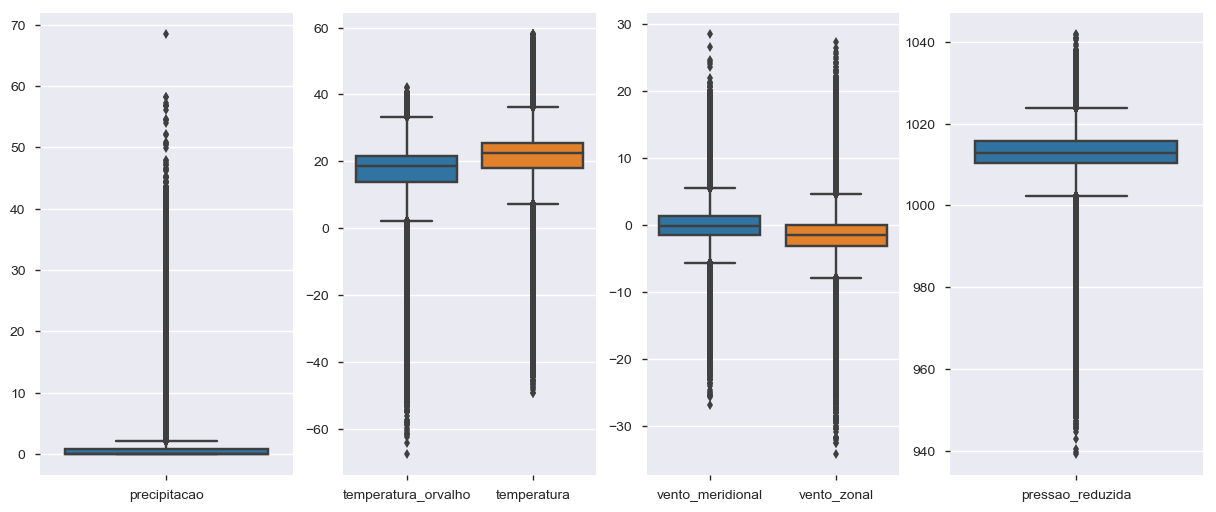

In [30]:
df_temperatura = df[['temperatura_orvalho','temperatura']]
df_vento = df[['vento_meridional','vento_zonal']]

f, axes = plt.subplots(ncols=4, nrows=1, figsize=(15, 6))
sns.set_style('darkgrid')
sns.boxplot(data=df[['precipitacao']], ax=axes[0]);
sns.boxplot(data=df_temperatura, ax=axes[1]);
sns.boxplot(data=df_vento, ax=axes[2]);
sns.boxplot(data=df[['pressao_reduzida']], ax=axes[3]);

O gráfico acima referente à precipitação apresenta assimetria, diferentemente da
simetria das outras variáveis climáticas. Tanto o sumário estatístico quando o box plot
foram montados com base nos dados do modelo global. Fazer a análise dos dados
separadamente de acordo com a sua resolução espacial pode favorecer na compreensão
dos outliers, que se apresentaram em grande quantidade nessa primeira análise.

### Visualização de amostragem dos dados

Amostragem de 5 estações, uma em cada região do Brasil.

In [21]:
df_5station = df.loc[(['83743','82331','83842','82598','83378'], '2014'),]
df_5station.reset_index(level='estacao', inplace=True)
df_5station['cidade'] = df_5station.estacao.map({'83743':'Rio de Janeiro', '82331':'Manaus', '83842':'Curitiba', 
                                   '82598':'Natal', '83378':'Brasília'})
df_5station.tail()

,estacao,latitude,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao,cidade
data,,,,,,,,,,
2014-12-30 18:00:00,83842,-25.42,-49.27,-0.428,-0.774,22.615,19.937,1009.95,5.6080,Curitiba
2014-12-31 00:00:00,83842,-25.42,-49.27,2.363,-0.482,21.873,19.111,1010.41,2.8455,Curitiba
2014-12-31 06:00:00,83842,-25.42,-49.27,0.501,-1.410,21.255,20.663,1009.27,0.0830,Curitiba
2014-12-31 12:00:00,83842,-25.42,-49.27,1.277,-2.208,24.971,19.992,1009.06,0.4670,Curitiba
2014-12-31 18:00:00,83842,-25.42,-49.27,1.604,-2.459,32.943,21.937,1006.64,0.0300,Curitiba


Embora os histogramas sejam intuitivos, a forma aparente da distribuição pode ser fortemente afetada pelo número de bins escolhidos. O gráfico de densidade  constrói uma estimativa da função de massa/densidade de probabilidade subjacente dos dados. Desta maneira, com o gráfico de densidade é mais fácil visualizar a distribuição dos dados.

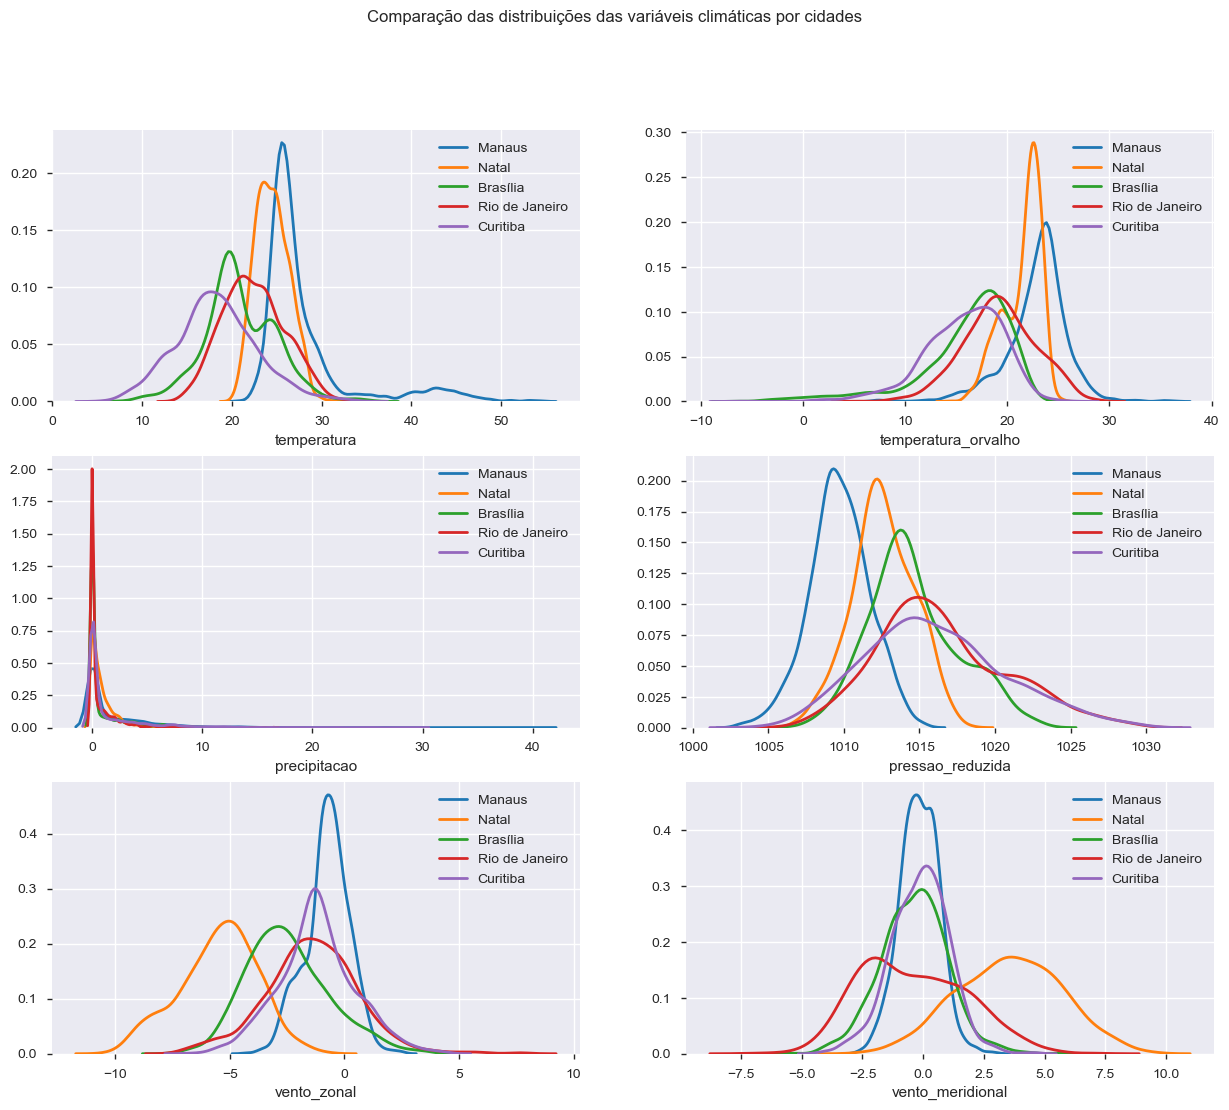

In [22]:
f, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 12))

for cidade in df_5station.cidade.unique():
    subset = df_5station[df_5station['cidade'] == cidade]    
    sns.distplot(subset['temperatura'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[0,0])
    sns.distplot(subset['temperatura_orvalho'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[0,1])
    sns.distplot(subset['precipitacao'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[1,0])
    sns.distplot(subset['pressao_reduzida'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[1,1])
    sns.distplot(subset['vento_zonal'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[2,0])
    sns.distplot(subset['vento_meridional'], hist=False, kde=True, kde_kws={'linewidth': 2}, label=cidade, ax=axes[2,1])
    
plt.suptitle('Comparação das distribuições das variáveis climáticas por cidades');

O gráfico de precipitação indica pouca dispersão dos dados e uma alta frequência
do valor zero, sendo difícil analisar o comportamento em cada região. Com isso, viu-se a
necessidade de analisar em mais detalhes essa variável.

In [23]:
df_rio = df_5station[df_5station.cidade == 'Rio de Janeiro']
df_rio_num = df_rio.select_dtypes(include = ['float64', 'int64'])
#df_rio_num.hist(figsize=(8, 8), bins=20, xlabelsize=8, ylabelsize=8);

### Análise dos dados de precipitação

Ao trabalhar com dados de séries temporais, muito pode ser revelado através da visualização dos dados,
como a sazonalidade e tendência. A primeira indica se os dados exibem um padrão
periódico claro, e a segunda, se os dados seguem um declive ascendente ou descendente
consistente.

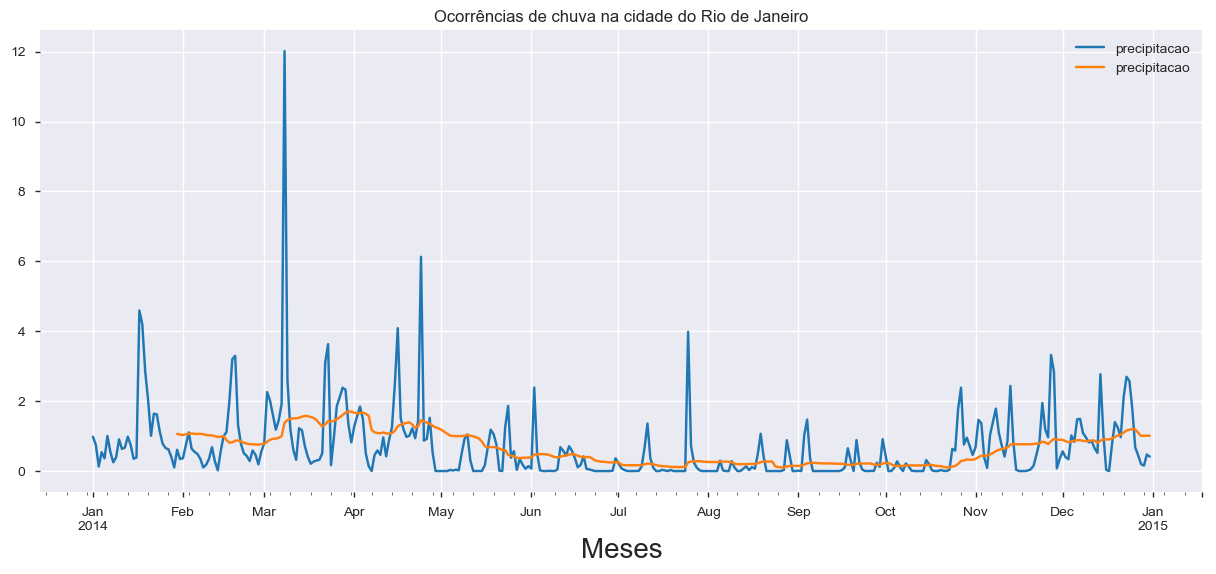

In [25]:
df_chuva = df_rio[['precipitacao']].resample('D').mean()
df_rm = pd.concat([df_chuva, df_chuva.rolling(30).mean()], axis=1)
df_rm.plot(figsize=(15,6));
plt.xlabel('Meses', fontsize=20);
plt.title('Ocorrências de chuva na cidade do Rio de Janeiro');

No gráfico acima, a linha azul indica os dados brutos das ocorrências de chuva na
cidade do Rio de Janeiro ao longo do ano de 2014. Devido à variabilidade das chuvas em
relação ao tempo, fica difícil analisar alguma tendência nos dados. É necessário suavizar
o ruído e a sazonalidade para identifica-la. Para isso, aplicou-se um método para redução
da variação chamado médias móveis, onde calcula-se a média dos primeiros n períodos
da série, colocando o resultado no período exatamente no centro deles. Progressivamente,
é acrescentado um período seguinte e desprezado o primeiro da média imediatamente
anterior, calculando novas médias que vão se movendo até o fim da série. Após aplicação
dessa técnica é possível visualizar a tendência da precipitação na cidade do Rio de
Janeiro: baixa ocorrência de chuvas entre os meses de maio a outubro, e um aumento na
frequência em dois períodos, dos meses de janeiro a abril e de novembro a dezembro.

### Correlação dos dados

Quando o objetivo é explorar a relação entre variáveis quantitativas com o
objetivo de construir modelos de predição ou construir a análise dos dados climáticos
atrelados a outras áreas de interesse, como mencionado na introdução, a estrutura de correlação é bastante útil na identificação desses relacionamentos. No Gráfico abaixo referente à cidade do Rio de Janeiro, observa-se uma correlação positiva entre
temperatura e ponto de orvalho, e também uma certa correlação negativa entre a temperatura e ponto de orvalho com a pressão do ar. As demais relações apresentam baixa correlação.

In [27]:
df.reset_index(level='estacao', inplace=True)
df['estacao'] = df['estacao'].astype('category')

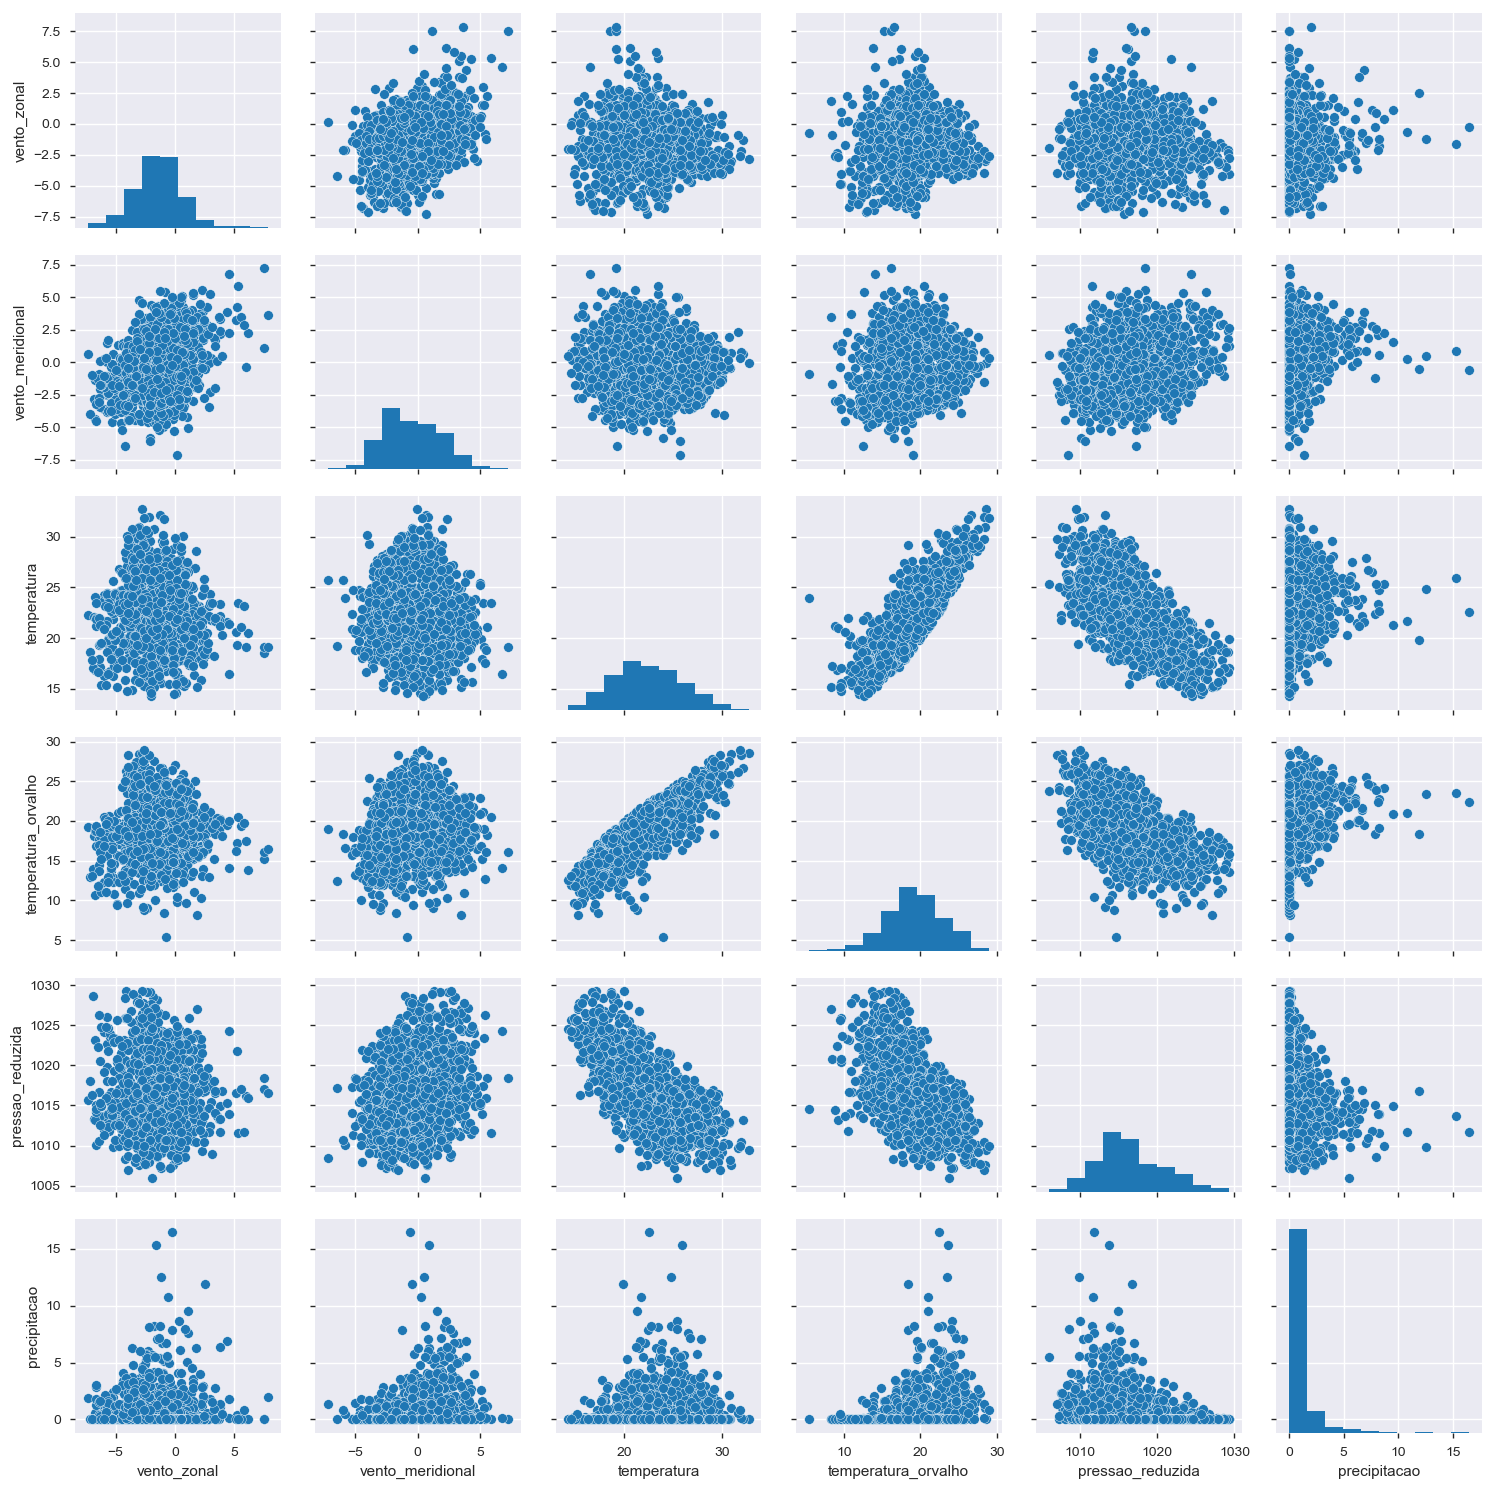

In [24]:
sns.pairplot(df_rio_num);

### Contagem de frequências

In [28]:
df.estacao.value_counts(dropna=False).head()

SAWG    1456
SAZM    1456
SAZS    1456
SBAA    1456
SBAF    1456
Name: estacao, dtype: int64

In [29]:
df.estacao.value_counts(dropna=False).tail()

A232    534
A237    534
F501    498
A046    312
A865    120
Name: estacao, dtype: int64

Observa-se que existem estações com poucas observações no *dataset*.

In [31]:
df.to_csv('./dados/T299x/2014/T299_2014_clean.csv', float_format='%g')